# Jo Wilder Session Data Exploration

This template is designed to help you explore per-session data from the Jo Wilder game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

# Environment Setup and Import

In [2]:
import os
print(os.getcwd())
!pip install --quiet --no-input -r ../../requirements.txt --log ./pip-installations.log

c:\Users\subsc\Documents\_work\FieldDay\OpenGameData\opengamedata-samples\JOWILDER\explore


In [3]:
# Standard Libraries
import math
import shutil
import urllib.request as urlrequest
from collections import Counter
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [4]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Retrieve Data Files

#### Please change the settings below to configure which game/server location you want to use.

<!-- `ogd_server` : The file server that contains the actual data files -->
* `game_id` : The game whose data you want to access.
* `mode` : The kind of data you want to retrieve. Should be one of `FileTypes.PLAYER`, `FileTypes.POPULATION`, `FileTypes.SESSION`, `FileTypes.EVENTS` or `FileTypes.ALL_EVENTS`

In [ ]:
game_id = 'AQUALAB'
mode    = FileTypes.EVENTS

NameError: name 'FileTypes' is not defined

In [ ]:
months_list = FileAPI.GetAvailableMonths(game_id)
print(f"The available months are:")
pprint(months_list, compact=True)

The available months are:
['4/2021', '5/2021', '6/2021', '7/2021', '8/2021', '9/2021', '10/2021',
 '11/2021', '12/2021', '1/2022', '2/2022', '3/2022', '4/2022', '5/2022',
 '6/2022', '7/2022', '8/2022', '9/2022', '10/2022', '11/2022', '12/2022',
 '1/2023', '2/2023', '3/2023', '4/2023', '5/2023', '6/2023']


In [ ]:
month = 2
year = 2023

# download the file if it doesn't exist.
zip_file, dataset_name = FileAPI.DownloadZippedDataset(game_id, month, year, mode)
zip_name = zip_file.filename

Found the file AQUALAB_20230201_to_20230228_5de1a1f_events.zip locally, nothing will be downloaded.


### Import Data Files to Jupyter

In [ ]:
raw_data = pd.DataFrame()

# Open TSV from the zip file.
MAX_ROWS = 10000 # for the sake of not overwhelming RAM, only read first 10,000 rows of an events file
tsv_name = f"{zip_name[:zip_name.rfind('.')]}.tsv"
with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
    raw_data = pd.read_csv(tsv_file, sep='\t', nrows=MAX_ROWS)
    data_readme = zip_file.read(f"{dataset_name}/readme.md")
zip_file.close()

# Data Overview

### Dataset README

Below, the readme file included with your dataset is displayed.
It includes information on the events and features for Wave Combinator.

In [8]:
# display(Markdown(data_readme.decode()))

### Data "Shape"

In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Columns: 3553 entries, Unnamed: 0 to persistentSessionID
dtypes: float64(3501), int64(33), object(19)
memory usage: 81.3+ MB


In [10]:
print(f"This dataset has {raw_data.shape[0]} Rows, {raw_data.shape[1]} Columns")

This dataset has 3000 Rows, 3553 Columns


### Column Names

Each Jo Wilder feature data file contains a large number of columns, each representing a single feature of gameplay.
Some features have one column per level, or one column per quiz question.
We call these **per-count** features.
Each **per-count** feature has a prefix indicating whether it was a *per-level* (prefix: `lvl`) *per-interaction* (prefix: `int`), *per-objective* (prefix: `obj`), *per-quiz-question* (prefix: `Q`), or *per-survey-question* (prefix: `SA`).  
Other features have only one column, based on play across all levels.
We call these **aggregate** or **session** features.

Below, the base feature names are listed.
**Per-count** features have the prefix shown in parentheses, and the number of columns with that base feature name shown to the right.
Note that **aggregate** features each have a "1" on the right, since each has just one column.

In [11]:
id_columns = pd.Index(["SessionID", "PlayerID"])

In [12]:
percount_prefixes = ['lvl', 'int', 'obj', 'Q', 'SA', 'R', 'S']
column_groups = {
  pre : []
  for pre in percount_prefixes + ['Aggregate']
}

for col in raw_data.columns:
  pieces = col.split('_', 1)
  prefix = pieces[0]
  found = False
  for pc_pre in percount_prefixes:
    if prefix.startswith(pc_pre):
      column_groups[pc_pre].append(f"({pc_pre}) {pieces[1]}")
      found = True
  if not found:
    column_groups['Aggregate'].append(col)
col_set = Counter(sum(column_groups.values(), []))
print(f"There are {len(raw_data.columns)} columns in {len(col_set)} groups:")
pprint(col_set, compact=False)

There are 3553 columns in 93 groups:
Counter({'(int) itime_to': 189,
         '(int) inum_enc': 189,
         '(int) ifirst_enc_duration': 189,
         '(int) itotal_duration': 189,
         '(int) ifirst_enc_boxes_read': 189,
         '(int) ifirst_enc_words_read': 189,
         '(int) ifirst_enc_avg_wps': 189,
         '(int) ifirst_enc_avg_tbps': 189,
         '(int) ifirst_enc_var_wps': 189,
         '(int) ifirst_enc_var_tbps': 189,
         '(obj) onext_int': 80,
         '(obj) onum_enc': 80,
         '(obj) ocount_clicks': 80,
         '(obj) omeaningful_action_count': 80,
         '(obj) ocount_notebook_uses': 80,
         '(obj) otime_to_next_obj': 80,
         '(lvl) EventCount': 48,
         '(lvl) count_clicks': 48,
         '(lvl) count_hovers': 48,
         '(lvl) time_in_level': 48,
         '(lvl) meaningful_action_count': 48,
         '(lvl) count_notebook_uses': 48,
         '(lvl) avg_time_between_clicks': 48,
         '(lvl) first_enc_words_read': 48,
         '(l

### Sample Rows

In [13]:
ROWS_TO_SHOW = 10

raw_data.head(ROWS_TO_SHOW)

Unnamed: 0  lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
0           0             28.0             36.0             55.0   
1           1             44.0             26.0             39.0   
2           2             21.0             35.0              NaN   
3           3              NaN              NaN              NaN   
4           4             32.0             22.0              NaN   
5           5              1.0              NaN              NaN   
6           6             36.0             40.0             72.0   
7           7             23.0             34.0             33.0   
8           8             27.0             56.0             41.0   
9           9             31.0             30.0             48.0   

   lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  \
0             59.0             83.0             30.0             98.0   
1             94.0             87.0             30.0            150.0   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   
5              NaN              NaN              NaN              NaN   
6              NaN              NaN              NaN              NaN   
7             21.0              NaN              NaN              NaN   
8              NaN              NaN              NaN              NaN   
9             40.0             69.0             42.0             82.0   

   lvl7_EventCount  lvl8_EventCount  lvl9_EventCount  lvl10_EventCount  \
0             48.0             26.0             44.0              18.0   
1             97.0              NaN              NaN               NaN   
2              NaN              NaN              NaN               NaN   
3              NaN              NaN              NaN               NaN   
4              NaN              NaN              NaN               NaN   
5              NaN              NaN              NaN               NaN   
6              NaN              NaN              NaN               NaN   
7              NaN              NaN              NaN               NaN   
8              NaN              NaN              NaN               NaN   
9              5.0              NaN              NaN               NaN   

   lvl11_EventCount  lvl12_EventCount  lvl13_EventCount  lvl14_EventCount  \
0              51.0             349.0              40.0              33.0   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   
5               NaN               NaN               NaN               NaN   
6               NaN               NaN               NaN               NaN   
7               NaN               NaN               NaN               NaN   
8               NaN               NaN               NaN               NaN   
9               NaN               NaN               NaN               NaN   

   lvl15_EventCount  lvl16_EventCount  lvl17_EventCount  lvl18_EventCount  \
0              32.0              44.0              50.0             165.0   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   
5               NaN               NaN               NaN               NaN   
6               NaN               NaN               NaN               NaN   
7               NaN               NaN               NaN               NaN   
8               NaN               NaN               NaN               NaN   
9               N

### Summary of raw data

In [14]:
raw_data.describe(include='all')

Unnamed: 0  lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
count   3000.000000      2512.000000      2197.000000      2046.000000   
unique          NaN              NaN              NaN              NaN   
top             NaN              NaN              NaN              NaN   
freq            NaN              NaN              NaN              NaN   
mean    1499.500000        34.150080        41.330451        54.035679   
std      866.169729        18.855087        24.862977        34.631560   
min        0.000000         1.000000         1.000000         1.000000   
25%      749.750000        25.000000        30.000000        40.000000   
50%     1499.500000        32.000000        36.000000        46.000000   
75%     2249.250000        41.000000        46.000000        56.000000   
max     2999.000000       343.000000       569.000000       396.000000   

        lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  \
count       1866.000000      1334.000000       1183.00000      1129.000000   
unique              NaN              NaN              NaN              NaN   
top                 NaN              NaN              NaN              NaN   
freq                NaN              NaN              NaN              NaN   
mean          73.551983        81.825337         44.89011       122.190434   
std           55.025032        30.186421         40.55966        61.571443   
min            2.000000         1.000000          1.00000         2.000000   
25%           43.000000        68.000000         20.00000        95.000000   
50%           59.000000        77.000000         29.00000       110.000000   
75%           88.000000        90.000000         54.00000       132.000000   
max          828.000000       323.000000        304.00000       831.000000   

        lvl7_EventCount  lvl8_EventCount  lvl9_EventCount  lvl10_EventCount  \
count       1029.000000       902.000000       864.000000        818.000000   
unique              NaN              NaN              NaN               NaN   
top                 NaN              NaN              NaN               NaN   
freq                NaN              NaN              NaN               NaN   
mean          73.613217        43.176275        60.672454         25.007335   
std           44.765646        14.256216        30.486102         16.484478   
min            1.000000         1.000000         1.000000          1.000000   
25%           49.000000        35.000000        46.000000         20.000000   
50%           61.000000        42.000000        54.000000         23.000000   
75%           85.000000        50.000000        67.000000         27.000000   
max          520.000000       145.000000       339.000000        430.000000   

        lvl11_EventCount  lvl12_EventCount  lvl13_EventCount  \
count         809.000000        701.000000        577.000000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean          108.362176        320.410842         41.247834   
std            70.666758        187.181561         15.798292   
min             1.000000          1.000000          1.000000   
25%            63.000000        212.000000         33.000000   
50%            85.000000        268.000000         38.000000   
75%           132.000000        377.000000         45.000000   
max           545.000000       2134.000000        207.000000   

        lvl14_EventCount  lvl15_EventCount  lvl16_EventCount  \
count         565.000000        552.000000        548.000000   
unique               NaN               NaN               NaN   
top                  NaN               NaN               NaN   
freq                 NaN               NaN               NaN   
mean           32.035398         75.615942         63.140511   
std            26.534244         80.837905         17.144838   
min             1

# Cleaning and Transforms

#### Convert data types in any cases where Pandas picked wrong type

In [15]:
typed_data = raw_data.replace({'None':None})

In [16]:
# typed_data = typed_data.convert_dtypes()

# For string types, try to parse as a timedelta, in case that's what was meant to be there (Pandas doesn't seem to do this automatically)
for col, dtype in zip(typed_data, typed_data.dtypes):
  if dtype == "string":
    try:
      typed_data[col] = pd.to_timedelta(typed_data[col])
    except:
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass
  elif dtype == "object":
      try:
        typed_data[col] = pd.to_numeric(typed_data[col])
      except:
        pass

print(f"This dataframe contains data of the following types:\n{typed_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{typed_data.dtypes}")

This dataframe contains data of the following types:
[dtype('int64') dtype('float64') dtype('O')]

Per feature, the data types are:
Unnamed: 0               int64
lvl0_EventCount        float64
lvl1_EventCount        float64
lvl2_EventCount        float64
lvl3_EventCount        float64
                        ...   
script_type              int64
script_version           int64
version                  int64
sessionID                int64
persistentSessionID      int64
Length: 3553, dtype: object


## Data Cleaning

#### Check for invalid Session IDs and null data.

In [17]:
bad_session_id = typed_data[typed_data.sessionID.isna()]
print(f"There are {bad_session_id.shape[0]} rows containing invalid Session IDs.")
bad_session_id.head(10)

There are 0 rows containing invalid Session IDs.


Empty DataFrame
Columns: [Unnamed: 0, lvl0_EventCount, lvl1_EventCount, lvl2_EventCount, lvl3_EventCount, lvl4_EventCount, lvl5_EventCount, lvl6_EventCount, lvl7_EventCount, lvl8_EventCount, lvl9_EventCount, lvl10_EventCount, lvl11_EventCount, lvl12_EventCount, lvl13_EventCount, lvl14_EventCount, lvl15_EventCount, lvl16_EventCount, lvl17_EventCount, lvl18_EventCount, lvl19_EventCount, lvl20_EventCount, lvl21_EventCount, lvl22_EventCount, lvl23_EventCount, lvl24_EventCount, lvl25_EventCount, lvl26_EventCount, lvl27_EventCount, lvl28_EventCount, lvl29_EventCount, lvl30_EventCount, lvl31_EventCount, lvl32_EventCount, lvl33_EventCount, lvl34_EventCount, lvl35_EventCount, lvl36_EventCount, lvl37_EventCount, lvl38_EventCount, lvl39_EventCount, lvl40_EventCount, lvl41_EventCount, lvl42_EventCount, lvl43_EventCount, lvl44_EventCount, lvl45_EventCount, lvl46_EventCount, lvl47_EventCount, lvl0_count_clicks, lvl1_count_clicks, lvl2_count_clicks, lvl3_count_clicks, lvl4_count_clicks, lvl5_count_clicks, lvl6_count_clicks, lvl7_count_clicks, lvl8_count_clicks, lvl9_count_clicks, lvl10_count_clicks, lvl11_count_clicks, lvl12_count_clicks, lvl13_count_clicks, lvl14_count_clicks, lvl15_count_clicks, lvl16_count_clicks, lvl17_count_clicks, lvl18_count_clicks, lvl19_count_clicks, lvl20_count_clicks, lvl21_count_clicks, lvl22_count_clicks, lvl23_count_clicks, lvl24_count_clicks, lvl25_count_clicks, lvl26_count_clicks, lvl27_count_clicks, lvl28_count_clicks, lvl29_count_clicks, lvl30_count_clicks, lvl31_count_clicks, lvl32_count_clicks, lvl33_count_clicks, lvl34_count_clicks, lvl35_count_clicks, lvl36_count_clicks, lvl37_count_clicks, lvl38_count_clicks, lvl39_count_clicks, lvl40_count_clicks, lvl41_count_clicks, lvl42_count_clicks, lvl43_count_clicks, lvl44_count_clicks, lvl45_count_clicks, lvl46_count_clicks, lvl47_count_clicks, lvl0_count_hovers, lvl1_count_hovers, lvl2_count_hovers, ...]
Index: []

In [18]:
null_data = typed_data.loc[:, typed_data.columns != 'PlayerID'][typed_data.isnull().any(axis = 1)]
print(f"There are {null_data.shape[0]} rows containing null data.\nFirst five rows containing null data:\n")
null_data.head(5)

There are 3000 rows containing null data.
First five rows containing null data:



Unnamed: 0  lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  \
0           0             28.0             36.0             55.0   
1           1             44.0             26.0             39.0   
2           2             21.0             35.0              NaN   
3           3              NaN              NaN              NaN   
4           4             32.0             22.0              NaN   

   lvl3_EventCount  lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  \
0             59.0             83.0             30.0             98.0   
1             94.0             87.0             30.0            150.0   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   

   lvl7_EventCount  lvl8_EventCount  lvl9_EventCount  lvl10_EventCount  \
0             48.0             26.0             44.0              18.0   
1             97.0              NaN              NaN               NaN   
2              NaN              NaN              NaN               NaN   
3              NaN              NaN              NaN               NaN   
4              NaN              NaN              NaN               NaN   

   lvl11_EventCount  lvl12_EventCount  lvl13_EventCount  lvl14_EventCount  \
0              51.0             349.0              40.0              33.0   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   lvl15_EventCount  lvl16_EventCount  lvl17_EventCount  lvl18_EventCount  \
0              32.0              44.0              50.0             165.0   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   lvl19_EventCount  lvl20_EventCount  lvl21_EventCount  lvl22_EventCount  \
0              71.0              33.0              71.0             171.0   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   lvl23_EventCount  lvl24_EventCount  lvl25_EventCount  lvl26_EventCount  \
0              46.0               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   lvl27_EventCount  lvl28_EventCount  lvl29_EventCount  lvl30_EventCount  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4               NaN               NaN               NaN               NaN   

   lvl31_EventCount  lvl32_EventCount  lvl33_EventCount  lvl34_EventCount  \
0               NaN               NaN               NaN               NaN   
1               NaN               NaN               NaN               NaN   
2               NaN               NaN               NaN               NaN   
3               NaN               NaN               NaN               NaN   
4         

#### Remove sessions based on NaNs in specific columns

In [19]:
# All sessions have some NaN data; choose any columns for which you'd like to drop sessions that had NaN in those specific columns:
# Note that the "count" in the summary indicates how many rows have non-null/non-NA values in them.
drop_nas = ["script_type"]

df_session = typed_data.dropna(subset=drop_nas)
df_session.reset_index(inplace=True)
print(f"After removing rows with NA values, there are {df_session.shape[0]} rows remaining")

After removing rows with NA values, there are 3000 rows remaining


## Finding outliers

Execute the following chunk only when the features are timedelta

In [20]:
# for col in target_columns:
#   df_Interested[col] = df_Interested[col].dt.total_seconds()


In [21]:
# bigoutliers = np.where(df_Interested[target_columns].ge(4000))
# bigoutliers

In [22]:
# for i, j in zip(bigoutliers[0], bigoutliers[1]):
#   df_Interested[target_columns].iat[i, j] = 0

## Data Transforms

# Feature Summaries

This section shows some basic statistical summaries of the feature columns listed previously.
These summaries are across all sessions in the data file.

#### Summary of Aggregate (whole-session) features

In [23]:
df_session[column_groups['Aggregate']].describe(include = 'all')

Unnamed: 0  sess_count_clicks  sess_count_hovers  \
count   3000.000000        3000.000000        3000.000000   
unique          NaN                NaN                NaN   
top             NaN                NaN                NaN   
freq            NaN                NaN                NaN   
mean    1499.500000         405.481333         125.624667   
std      866.169729         494.738722         187.847463   
min        0.000000           0.000000           0.000000   
25%      749.750000          46.000000           0.000000   
50%     1499.500000         197.000000          40.000000   
75%     2249.250000         583.000000         167.000000   
max     2999.000000        5214.000000        2075.000000   

        sess_meaningful_action_count  sess_EventCount  \
count                    3000.000000      3000.000000   
unique                           NaN              NaN   
top                              NaN              NaN   
freq                             NaN              NaN   
mean                       62.028667       559.609667   
std                        78.394475       705.447368   
min                         0.000000         1.000000   
25%                         6.000000        61.000000   
50%                        29.000000       251.500000   
75%                        90.000000       799.250000   
max                       647.000000      9306.000000   

        sess_count_notebook_uses  sess_avg_time_between_clicks  \
count                3000.000000                   3000.000000   
unique                       NaN                           NaN   
top                          NaN                           NaN   
freq                         NaN                           NaN   
mean                    3.826000                     12.081025   
std                     6.819376                    169.823068   
min                     0.000000                      0.000000   
25%                     0.000000                      1.117726   
50%                     1.000000                      1.748274   
75%                     4.000000                      2.534158   
max                    62.000000                   7845.476667   

        sess_first_enc_words_read  sess_first_enc_boxes_read  sess_num_enc  \
count                      3000.0                     3000.0   3000.000000   
unique                        NaN                        NaN           NaN   
top                           NaN                        NaN           NaN   
freq                          NaN                        NaN           NaN   
mean                          0.0                        0.0     37.793000   
std                           0.0                        0.0     49.011456   
min                           0.0                        0.0      0.000000   
25%                           0.0                        0.0      6.000000   
50%                           0.0                        0.0     16.000000   
75%                           0.0                        0.0     50.000000   
max                           0.0                        0.0    850.000000   

        sess_first_enc_duration  sess_first_enc_avg_wps  \
count              3.000000e+03                  3000.0   
unique                      NaN                     NaN   
top                         NaN                     NaN   
freq                        NaN                     NaN   
mean               2.141375e+03                     0.0   
std                5.643616e+04                     0.0   
min                0.000000e+00                     0.0   
25%                2.300950e+01                     0.0   
50%                1.061305e+02                     0.0   
75%                3.982507e+02                     0.0   
max                3.035520e+06                     0.0   

        sess_first_enc_var_wps  sess_first_enc_avg_tbps  \
count                   3000.0                   3000.0   
unique                     NaN    

#### Summary of a Per-Count feature

In [24]:
# Choose which per-count feature you'd like to see summarized
per_count = "EventCount"

cols = [col for col in raw_data.columns if col.endswith(per_count)]
raw_data[cols].describe(include='all')

lvl0_EventCount  lvl1_EventCount  lvl2_EventCount  lvl3_EventCount  \
count      2512.000000      2197.000000      2046.000000      1866.000000   
mean         34.150080        41.330451        54.035679        73.551983   
std          18.855087        24.862977        34.631560        55.025032   
min           1.000000         1.000000         1.000000         2.000000   
25%          25.000000        30.000000        40.000000        43.000000   
50%          32.000000        36.000000        46.000000        59.000000   
75%          41.000000        46.000000        56.000000        88.000000   
max         343.000000       569.000000       396.000000       828.000000   

       lvl4_EventCount  lvl5_EventCount  lvl6_EventCount  lvl7_EventCount  \
count      1334.000000       1183.00000      1129.000000      1029.000000   
mean         81.825337         44.89011       122.190434        73.613217   
std          30.186421         40.55966        61.571443        44.765646   
min           1.000000          1.00000         2.000000         1.000000   
25%          68.000000         20.00000        95.000000        49.000000   
50%          77.000000         29.00000       110.000000        61.000000   
75%          90.000000         54.00000       132.000000        85.000000   
max         323.000000        304.00000       831.000000       520.000000   

       lvl8_EventCount  lvl9_EventCount  lvl10_EventCount  lvl11_EventCount  \
count       902.000000       864.000000        818.000000        809.000000   
mean         43.176275        60.672454         25.007335        108.362176   
std          14.256216        30.486102         16.484478         70.666758   
min           1.000000         1.000000          1.000000          1.000000   
25%          35.000000        46.000000         20.000000         63.000000   
50%          42.000000        54.000000         23.000000         85.000000   
75%          50.000000        67.000000         27.000000        132.000000   
max         145.000000       339.000000        430.000000        545.000000   

       lvl12_EventCount  lvl13_EventCount  lvl14_EventCount  lvl15_EventCount  \
count        701.000000        577.000000        565.000000        552.000000   
mean         320.410842         41.247834         32.035398         75.615942   
std          187.181561         15.798292         26.534244         80.837905   
min            1.000000          1.000000          1.000000          1.000000   
25%          212.000000         33.000000         22.000000         42.000000   
50%          268.000000         38.000000         26.000000         53.000000   
75%          377.000000         45.000000         32.000000         79.000000   
max         2134.000000        207.000000        252.000000        982.000000   

       lvl16_EventCount  lvl17_EventCount  lvl18_EventCount  lvl19_EventCount  \
count        548.000000        543.000000        531.000000        475.000000   
mean          63.140511         63.808471        174.625235         65.482105   
std           17.144838         44.177186         81.840093         50.327463   
min            1.000000          1.000000          1.000000          3.000000   
25%           52.000000         43.000000        133.000000         39.000000   
50%           63.000000         53.000000        158.000000         49.000000   
75%           71.250000         71.000000        195.000000         72.000000   
max          180.000000        544.000000        705.000000        427.000000   

       lvl20_EventCount  lvl21_EventCount  lvl22_EventCount  lvl23_EventCount  \
count        450.000000         433.00000        412.000000        389.000000   
mean          64.908889         114.34873        149.861650         67.239075   
std           85.584370         115.57864        157.166664         22.056206   
min            2.000000           1.00000          1.000000          3.000000   
25%           38.000000          68.00000 

# Visualizations

### Simple feature value distribution visualization

In [25]:
feature_to_visualize = "sess_num_enc"
minimum_value = -math.inf
maximum_value = math.inf

range_filter = (df_session[feature_to_visualize] > minimum_value) & (df_session[feature_to_visualize] < maximum_value)
plot_data = df_session[feature_to_visualize][range_filter]
print(plot_data.describe())

count    3000.000000
mean       37.793000
std        49.011456
min         0.000000
25%         6.000000
50%        16.000000
75%        50.000000
max       850.000000
Name: sess_num_enc, dtype: float64


Text(0.5, 0, 'sess_num_enc')

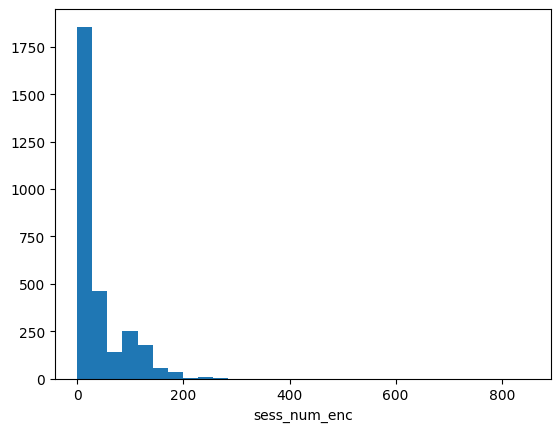

In [26]:
f, ax = plt.subplots()
ax.hist(plot_data, bins=30)
ax.set_xlabel(feature_to_visualize)

### Simple feature comparison scatterplot

In [27]:
x_axis_feature = "sess_count_notebook_uses"
minimum_x_value = -math.inf
maximum_x_value = math.inf
y_axis_feature = "sess_time_idle"
minimum_y_value = -math.inf
maximum_y_value = math.inf

range_filter = (df_session[x_axis_feature] > minimum_x_value) & (df_session[x_axis_feature] < maximum_x_value) \
             & (df_session[y_axis_feature] > minimum_y_value) & (df_session[y_axis_feature] < maximum_y_value)
scatter_data = df_session[[x_axis_feature, y_axis_feature]][range_filter]
print(scatter_data.describe())

       sess_count_notebook_uses  sess_time_idle
count               3000.000000    3.000000e+03
mean                   3.826000    4.330450e+03
std                    6.819376    6.376317e+04
min                    0.000000    0.000000e+00
25%                    0.000000    0.000000e+00
50%                    1.000000    3.959200e+01
75%                    4.000000    1.437690e+02
max                   62.000000    3.035079e+06


Text(0, 0.5, 'sess_time_idle')

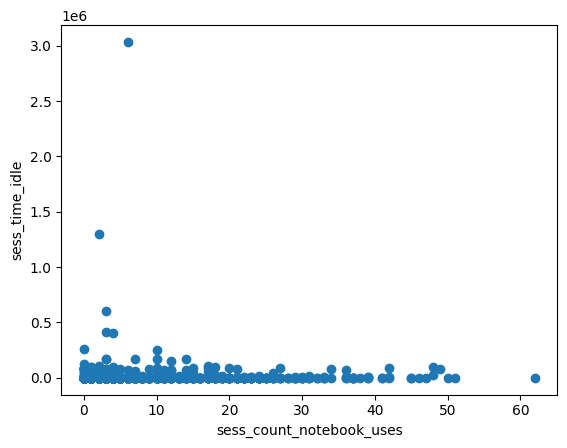

In [28]:
f, ax = plt.subplots()
ax.scatter(scatter_data[x_axis_feature], scatter_data[y_axis_feature])
ax.set_xlabel(x_axis_feature)
ax.set_ylabel(y_axis_feature)

## How Many Players?

In [29]:
# Not just "how many played at all", but "how many played and had some interactions", or "played at least one minute."
played_3_encounters = df_session[df_session['sess_num_enc'] >= 3]


In [30]:
print(f"There were {df_session.shape[0]} sessions in the dataset (after cleaning).\nOf those, {played_3_encounters.shape[0]} sessions had at least 3 interactions.")

There were 3000 sessions in the dataset (after cleaning).
Of those, 2417 sessions had at least 3 interactions.


## How Far Did They Get?

Text(0.5, 1.0, 'Histogram for Max Level Reached')

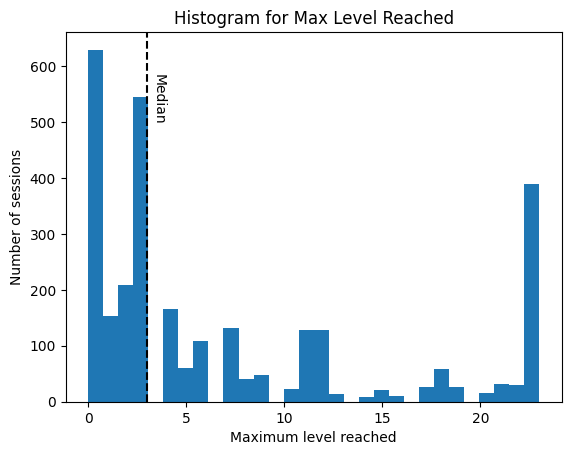

In [31]:
f, ax = plt.subplots()
ax.hist(df_session['max_level'], bins=30)
ax.axvline(x=df_session['max_level'].median(), linestyle='--', color='k', label="Median")
ax.text(x=df_session['max_level'].median() + 0.25, y=500, s="Median", rotation=-90)
ax.set_xlabel("Maximum level reached")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Max Level Reached")

## How Long Did They Play?

In [32]:
time_feature = "sess_time_active"
df_session[time_feature].describe()

count    3000.000000
mean      594.368172
std       732.797041
min        -0.266000
25%        67.248000
50%       290.864000
75%       871.035500
max      5067.736000
Name: sess_time_active, dtype: float64

In [33]:
minimum_value = 0
maximum_value = 1500

range_filter = (df_session[time_feature] > minimum_value) & (df_session[time_feature] < maximum_value)
time_data = df_session[time_feature][range_filter]
time_data.describe()

count    2157.000000
mean      420.785706
std       382.914055
min         0.692000
25%       132.283000
50%       293.234000
75%       600.208000
max      1499.584000
Name: sess_time_active, dtype: float64

Text(0.5, 1.0, 'Histogram for Total Active Time')

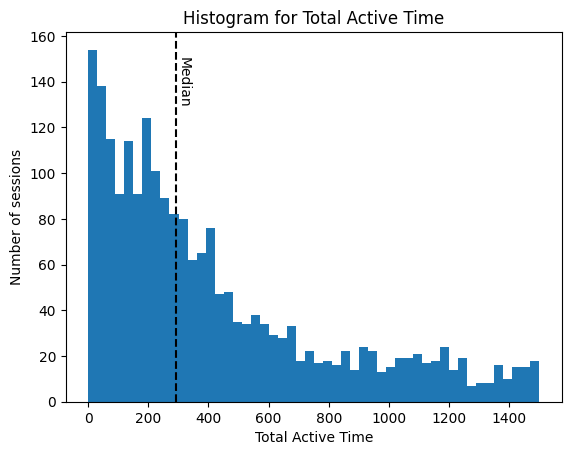

In [34]:
f, ax = plt.subplots()
ax.hist(time_data, bins=50)
ax.axvline(x=time_data.median(), linestyle='--', color='k', label="Median")
ax.text(x=time_data.median() + 0.25, y=130, s="Median", rotation=-90)
ax.set_xlabel("Total Active Time")
ax.set_ylabel("Number of sessions")
ax.set_title("Histogram for Total Active Time")

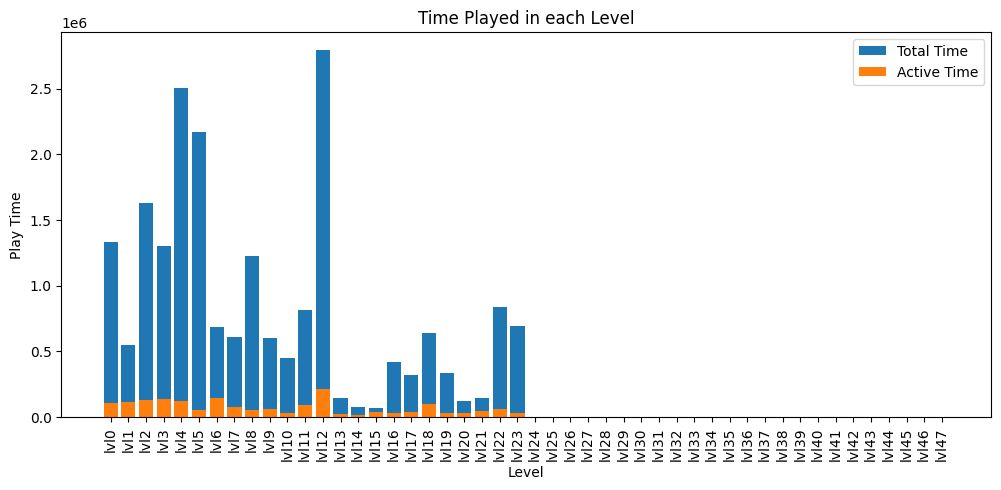

In [38]:
level_time_columns = df_session[df_session.columns[df_session.columns.str.endswith("time_in_level")]]
level_active_time_columns = df_session[df_session.columns[(df_session.columns.str.startswith("lvl")) & (df_session.columns.str.endswith("time_active"))]]
per_level_total_time = level_time_columns.sum(axis=0)
per_level_total_active_time = level_active_time_columns.sum(axis=0)

f,ax = plt.subplots(figsize=(12, 5), sharex=True, sharey=True)
ax.bar([col.split('_')[0] for col in level_time_columns.columns], per_level_total_time, label="Total Time")
ax.tick_params(axis='x', labelrotation=90)
ax.bar([col.split('_')[0] for col in level_active_time_columns.columns], per_level_total_active_time, label="Active Time")
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Level")
ax.set_ylabel("Play Time")
ax.set_title("Time Played in each Level")
ax.legend()

next question: what do we want for the tests/visualizations/research?
do we need to step further into our feature systems

# Pairwise test

In [48]:
types = {0:'Dry', 1:'No Humor', 2:'No Snark', 3:'Normal'}
df_session['script_name'] = df_session['script_type'].map(types)

In [51]:
#@markdown Choose your own metric for test here
response_variable = "max_level"
independent_variable = "script_name" #@param {type:'string'}

Text(0.5, 1.0, 'Histogram for script_name')

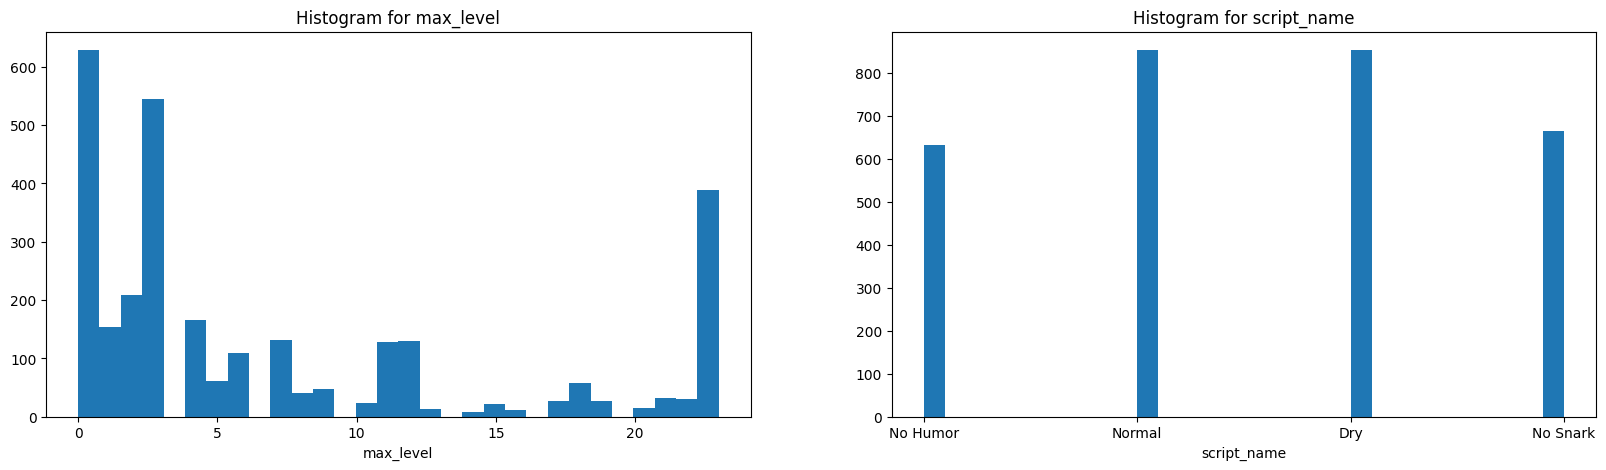

In [54]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax[0].hist(df_session[response_variable], bins=30)
ax[0].set_xlabel(f"{response_variable}")
ax[0].set_title(f"Histogram for {response_variable}")
ax[1].hist(df_session[independent_variable], bins=30)
ax[1].set_xlabel(independent_variable)
ax[1].set_title(f"Histogram for {independent_variable}")

In [53]:
pairwise = pairwise_tukeyhsd(endog=df_session[response_variable], groups=df_session[independent_variable], alpha=0.05)
print(pairwise)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
     Dry No Humor    1.228 0.0163  0.1624 2.2937   True
     Dry No Snark   2.2761    0.0  1.2257 3.3264   True
     Dry   Normal   1.9941    0.0  1.0113 2.9769   True
No Humor No Snark    1.048 0.0796   -0.08 2.1761  False
No Humor   Normal   0.7661  0.251 -0.2993 1.8315  False
No Snark   Normal   -0.282 0.9009  -1.332 0.7681  False
-------------------------------------------------------
